In [2]:
import sunpy
import sunpy.map
import numpy as np
from math import *
import astropy.units as u
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sunpy.coordinates import frames
import matplotlib.gridspec as gridspec
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
from matplotlib.patches import ConnectionPatch

import os
import sys
sys.path.append(os.path.expanduser("~/course/231503031/solarphy/3d_velocity"))
from src import alignment, classification


/home/AIIAcourse/.conda/envs/231503031/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visuals

In [3]:
from astropy.io import fits

data_dir = "/data1/yiwen/event_analysis/noaa_14272/chase"
files = os.listdir(os.path.expanduser(data_dir))
print(files)
rsms = []
for file in files:
    print(file)
    rsm = fits.open(os.path.join(data_dir, file))
    rsms.append(rsm)

# sort by time
from astropy.time import Time
def get_obstime(rsm):
    obstime_str = rsm[1].header['DATE_OBS'].replace('T', ' ')
    obstime = Time(obstime_str)
    return obstime

rsms.sort(key=get_obstime)

['RSM20251114T183507_0004_HA.fits', 'RSM20251114T183135_0001_HA.fits', 'RSM20251114T184919_0016_HA.fits', 'RSM20251114T184325_0011_HA.fits', 'RSM20251114T183619_0005_HA.fits', 'RSM20251114T183841_0007_HA.fits', 'RSM20251114T184547_0013_HA.fits', 'RSM20251114T184103_0009_HA.fits', 'RSM20251114T183357_0003_HA.fits', 'RSM20251114T183729_0006_HA.fits', 'RSM20251114T184657_0014_HA.fits', 'RSM20251114T184809_0015_HA.fits', 'RSM20251114T183951_0008_HA.fits', 'RSM20251114T183245_0002_HA.fits', 'RSM20251114T184435_0012_HA.fits', 'RSM20251114T184213_0010_HA.fits', 'RSM20251114T185031_0017_HA.fits']
RSM20251114T183507_0004_HA.fits
RSM20251114T183135_0001_HA.fits
RSM20251114T184919_0016_HA.fits
RSM20251114T184325_0011_HA.fits
RSM20251114T183619_0005_HA.fits
RSM20251114T183841_0007_HA.fits
RSM20251114T184547_0013_HA.fits
RSM20251114T184103_0009_HA.fits
RSM20251114T183357_0003_HA.fits
RSM20251114T183729_0006_HA.fits
RSM20251114T184657_0014_HA.fits
RSM20251114T184809_0015_HA.fits
RSM20251114T183951_0

In [4]:
demo_rsm = rsms[0]
hacore = demo_rsm[1].data[68, :, :]
hawing = demo_rsm[1].data[-10, :, :]
#generate maps

#look header in demo_rsm
print(demo_rsm[1].header)
#parse time from file_name
# yyyy-mm-ddThh:mm:ss UTC+8
obstime = demo_rsm[1].header['DATE_OBS'].replace('T', ' ')
from astropy.time import Time
obstime_utc = Time(obstime)   # 向前 shift 8 小时到 UTC

coord_HIS = SkyCoord(0 * u.arcsec, 0 * u.arcsec, obstime = obstime_utc, observer = 'earth', frame = frames.Helioprojective)
headerwing = sunpy.map.make_fitswcs_header(hawing, coord_HIS,
                                       reference_pixel = \
                                       [rsm[1].header['CRPIX1'], rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')
headercore = sunpy.map.make_fitswcs_header(hacore, coord_HIS,
                                       reference_pixel = \
                                       [rsm[1].header['CRPIX1'], rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')
hawing_map = sunpy.map.Map(hawing, headerwing)
hacore_map = sunpy.map.Map(hacore, headercore)

XTENSION= 'IMAGE   '           / binary table extension                         BITPIX  =                   16 / data type of original image                    NAXIS   =                    3 / Number of data axes                            NAXIS1  =                 2304 / Length of data axis 1 (slit dimension)         NAXIS2  =                 2313 / Length of data axis 2 (scanning steps)         NAXIS3  =                  118 / Length of data axis 3 (wavelength dimension)   PCOUNT  =                    0 / number of group parameters                     GCOUNT  =                    1 / number of groups                               TELESCOP= 'CHASE-HIS'          / Telescop Name                                  BIN     =                    2 / Binning mode                                   DATE_OBS= '2025-11-14T18:31:35' / Observation time                              CRPIX1  =    1178.898301055725 / X coordinate of solar center in pixel          CUNIT1  = 'arcsec  '           / unit of

<Figure size 640x480 with 0 Axes>

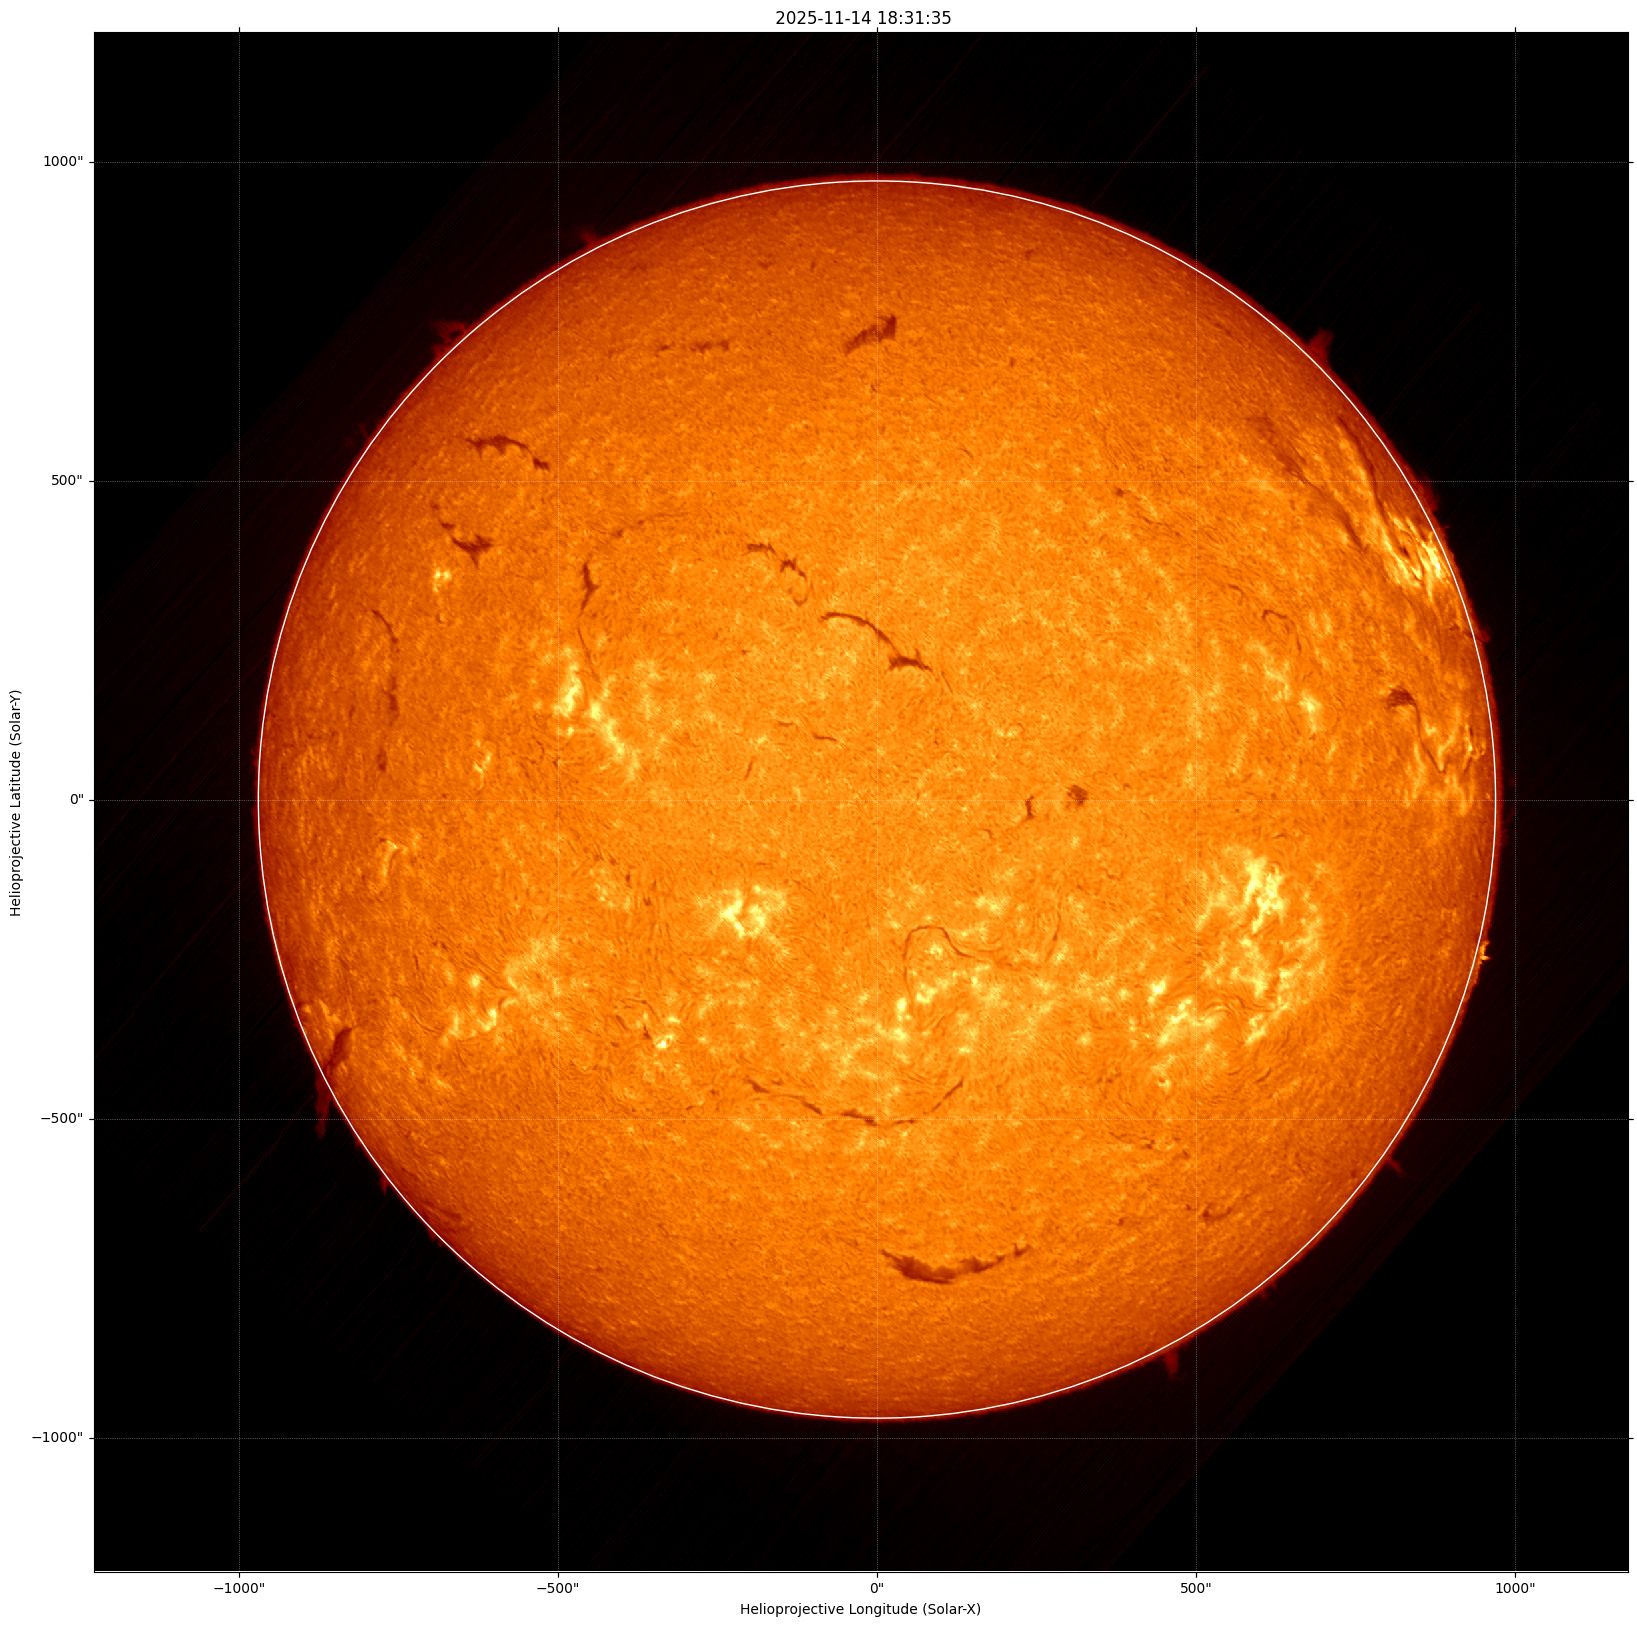

In [5]:
fig = plt.figure()
fig = plt.figure(figsize = (20, 20))
hacore_map.plot(cmap = 'afmhot' , vmin = 0, vmax = 4 * hacore.mean())
#hacore_map.draw_grid(color = 'white')
hacore_map.draw_limb()
plt.show()

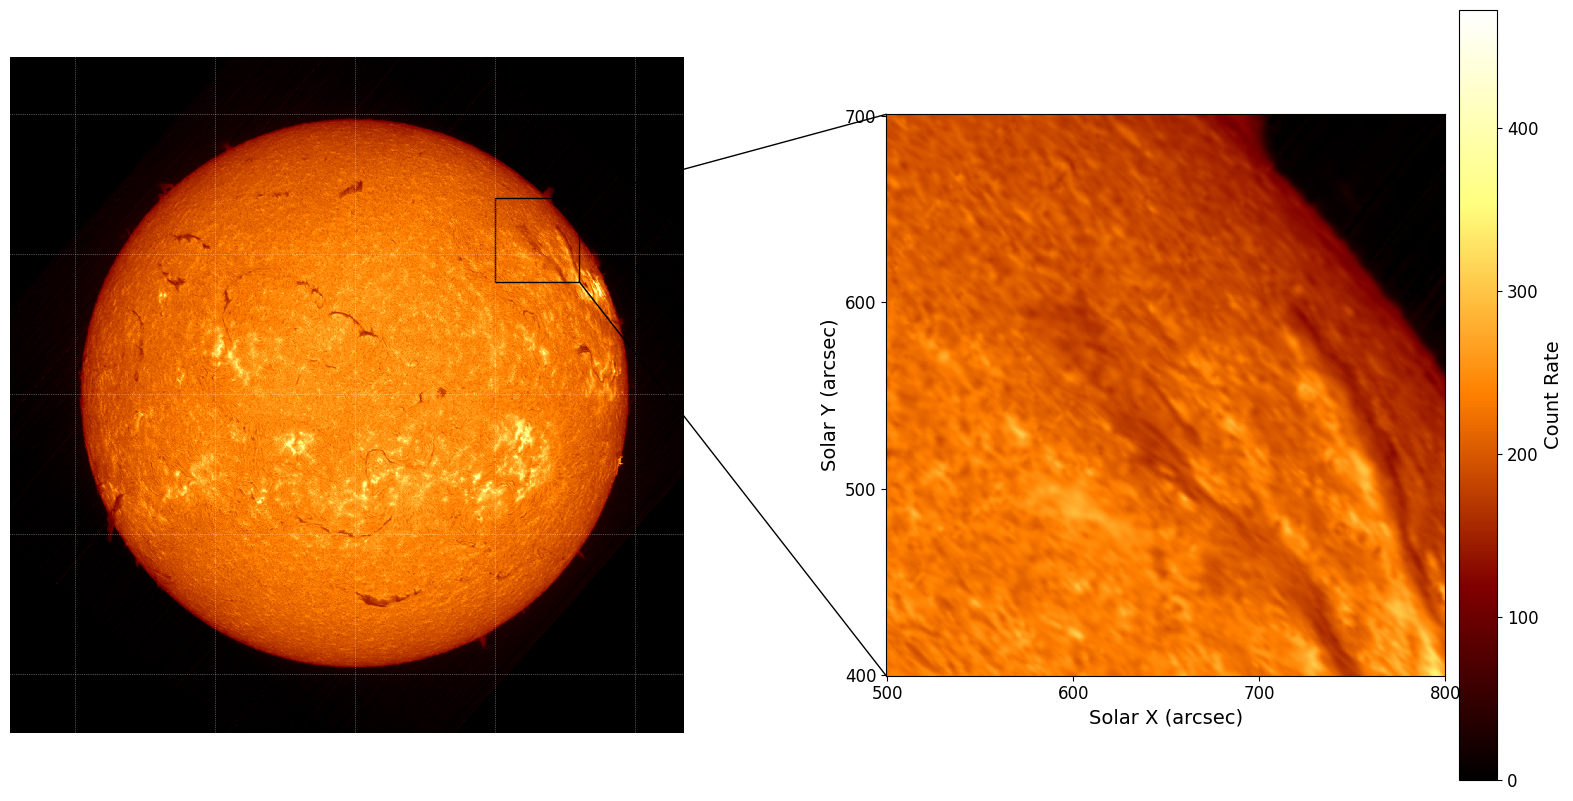

In [6]:
# draw a subplot of demo_rsm hacore

demo_rsm = rsms[0]
headerwing = sunpy.map.make_fitswcs_header(hawing, coord_HIS,
                                       reference_pixel = \
                                       [demo_rsm[1].header['CRPIX1'], demo_rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')
headercore = sunpy.map.make_fitswcs_header(hacore, coord_HIS,
                                       reference_pixel = \
                                       [demo_rsm[1].header['CRPIX1'], demo_rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')
hawing_map = sunpy.map.Map(hawing, headerwing)
hacore_map = sunpy.map.Map(hacore, headercore)
ang_res = 0.5218 * 2

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(1, 2, wspace=0.3)

# 主图
ax1 = fig.add_subplot(gs[0, 0], projection=hacore_map)
hacore_map.plot(axes=ax1, title='', cmap='afmhot', vmin=0, vmax=4 * hacore_map.mean())
plt.grid(False)

# 定义子图区域
left, right, bottom, top = 500, 800, 400, 700
left_corner = SkyCoord(Tx=left * u.arcsec, Ty=bottom * u.arcsec, frame=hacore_map.coordinate_frame)
right_corner = SkyCoord(Tx=right * u.arcsec, Ty=top * u.arcsec, frame=hacore_map.coordinate_frame)

# 隐藏坐标轴标签
for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

# 在主图上画框
hacore_map.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)

# 提取子图数据
hacore_map_small = hacore_map.submap(left_corner, top_right=right_corner)
hacore_map_small = hacore_map_small.data

# 绘制子图
ax2 = fig.add_subplot(gs[0, 1])
len_arc = (right - left) / 100 + 1
tick_pixelx = list(np.linspace(0, (right - left) / ang_res, int(len_arc)))
tick_pixely = list(np.linspace(0, (top - bottom) / ang_res, int(len_arc)))
tick_arcsecx = [int(i) for i in np.linspace(left, right, int(len_arc))]
tick_arcsecy = [int(i) for i in np.linspace(bottom, top, int(len_arc))]

im = ax2.imshow(hacore_map_small, origin='lower', cmap='afmhot', vmin=0, vmax=4 * hacore_map.mean())
ax2.set_xlabel('Solar X (arcsec)', fontsize=14)
ax2.set_ylabel('Solar Y (arcsec)', fontsize=14)
ax2.set_xticks(tick_pixelx)
ax2.set_xticklabels(tick_arcsecx, fontsize=12)
ax2.set_yticks(tick_pixely)
ax2.set_yticklabels(tick_arcsecy, fontsize=12)

# 添加连接线
xpix, ypix = hacore_map.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1), (xpix.value, ypix.value), 'axes fraction', 'data', 
    axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1
)
xpix, ypix = hacore_map.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=hacore_map.coordinate_frame))
con2 = ConnectionPatch(
    (0, 0), (xpix.value, ypix.value), 'axes fraction', 'data', 
    axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1
)
ax2.add_artist(con1)
ax2.add_artist(con2)

# 添加颜色条
cbar = fig.colorbar(im, ax=ax2, pad=0.02)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Count Rate', fontsize=14)

plt.show()

In [7]:
aligned_data, shifts = alignment.align_images_by_crpix(rsms, reference_idx=0)
from src.video_generation import create_aligned_video
#print(create_aligned_video(aligned_data, rsms, output_dir='./visuals'))

Frame 0: shift = [0.00, 0.00] pixels
Frame 1: shift = [5.29, 8.95] pixels
Frame 2: shift = [0.97, -1.74] pixels
Frame 3: shift = [6.40, 9.19] pixels
Frame 4: shift = [0.92, -1.64] pixels
Frame 5: shift = [5.54, 8.27] pixels
Frame 6: shift = [1.03, -0.45] pixels
Frame 7: shift = [4.60, 9.44] pixels
Frame 8: shift = [0.10, -0.39] pixels
Frame 9: shift = [6.58, 8.61] pixels
Frame 10: shift = [2.00, -1.25] pixels
Frame 11: shift = [6.70, 9.73] pixels
Frame 12: shift = [1.18, -0.04] pixels
Frame 13: shift = [5.77, 8.96] pixels
Frame 14: shift = [1.29, 2.10] pixels
Frame 15: shift = [6.75, 10.08] pixels
Frame 16: shift = [1.24, 3.24] pixels


In [8]:
from src.alignment import align_submaps_by_crpix
from src.video_generation import create_aligned_subplot_video

submaps_aligned, submap_shifts = align_submaps_by_crpix(
    rsms, left, right, bottom, top, reference_idx=0
)

#create_aligned_subplot_video(submaps_aligned, rsms, left, right, bottom, top, output_dir='./visuals')


Frame 0: shift = [0.00, 0.00] pixels
Frame 1: shift = [6.29, 8.95] pixels
Frame 2: shift = [0.97, -1.74] pixels
Frame 3: shift = [7.40, 9.19] pixels
Frame 4: shift = [0.92, -1.64] pixels
Frame 5: shift = [6.54, 8.27] pixels
Frame 6: shift = [1.03, -0.45] pixels
Frame 7: shift = [5.60, 9.44] pixels
Frame 8: shift = [0.10, -1.39] pixels
Frame 9: shift = [7.58, 8.61] pixels
Frame 10: shift = [2.00, -2.25] pixels
Frame 11: shift = [7.70, 8.73] pixels
Frame 12: shift = [1.18, -1.04] pixels
Frame 13: shift = [6.77, 7.96] pixels
Frame 14: shift = [1.29, 1.10] pixels
Frame 15: shift = [7.75, 9.08] pixels
Frame 16: shift = [2.24, 2.24] pixels


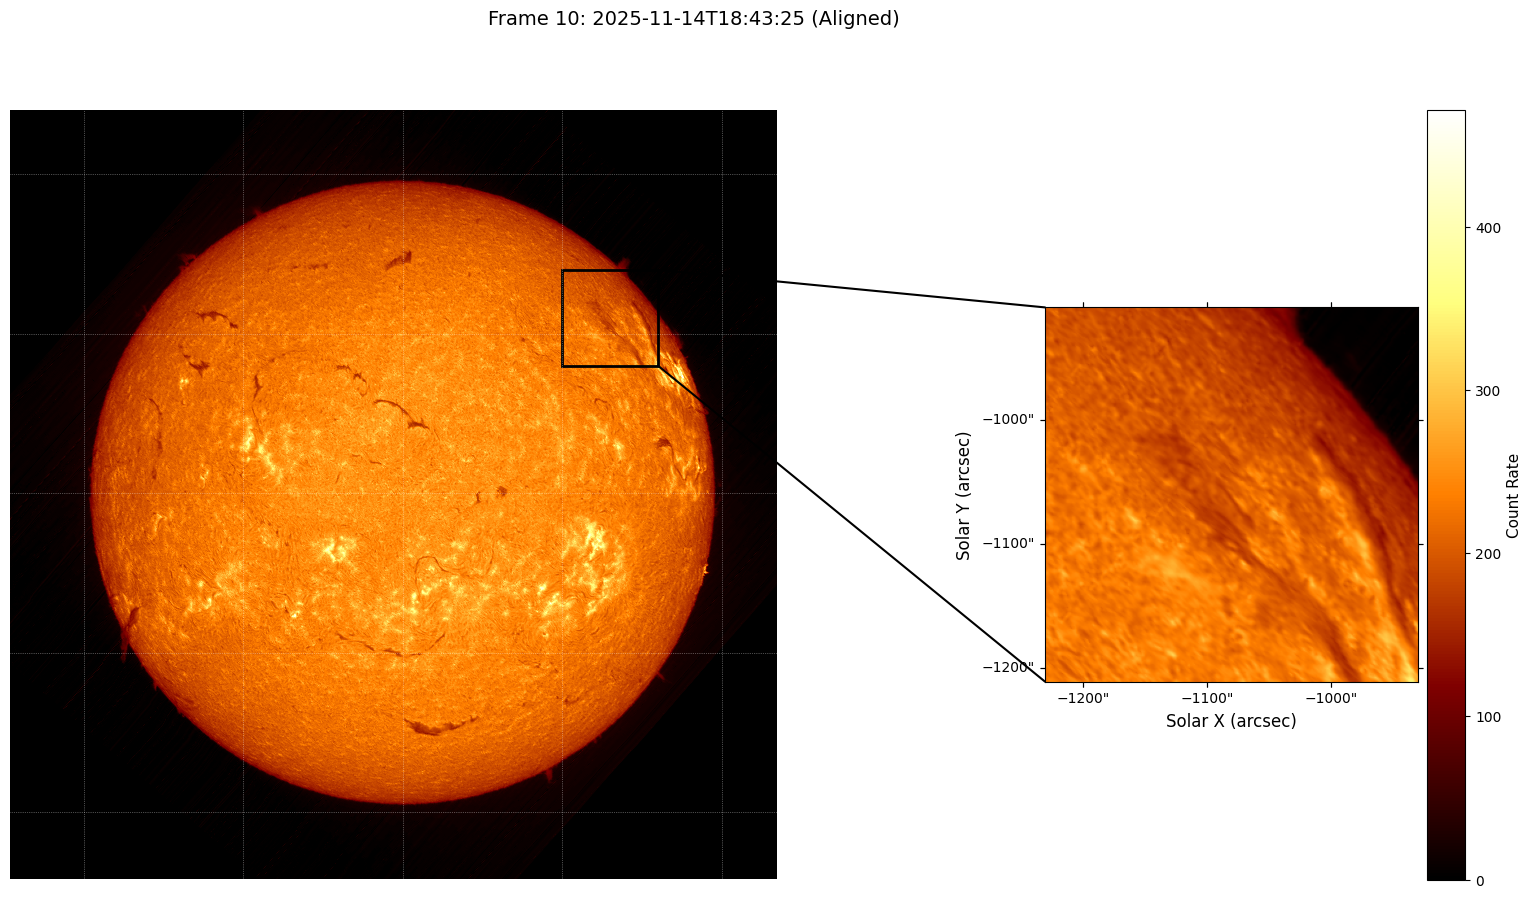

In [9]:
idx = 10
figsize=(20, 10)

ang_res = 0.5218 * 2
ref_crpix1 = rsms[0][1].header['CRPIX1']
ref_crpix2 = rsms[0][1].header['CRPIX2']


rsm = rsms[idx]
obstime = rsm[1].header['DATE_OBS']
coord_HIS = SkyCoord(0 * u.arcsec, 0 * u.arcsec, obstime=obstime,
                    observer='earth', frame=frames.Helioprojective)

header = sunpy.map.make_fitswcs_header(
    hacore, coord_HIS,
    reference_pixel=[ref_crpix1, ref_crpix2] * u.pixel,
    scale=[0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
    telescope='CHASE', instrument='RSM'
)
hacore_map = sunpy.map.Map(hacore, header)

# Create subregion box
left_corner = SkyCoord(Tx=left * u.arcsec, Ty=bottom * u.arcsec,
                        frame=hacore_map.coordinate_frame)
right_corner = SkyCoord(Tx=right * u.arcsec, Ty=top * u.arcsec,
                        frame=hacore_map.coordinate_frame)
hacore_submap = hacore_map.submap(left_corner, top_right=right_corner).data

# Calculate axis coordinates
len_arc = (right - left) / 100 + 1
tick_pixelx = list(np.linspace(0, (right - left) / ang_res, int(len_arc)))
tick_pixely = list(np.linspace(0, (top - bottom) / ang_res, int(len_arc)))
tick_arcsecx = [int(i) for i in np.linspace(left, right, int(len_arc))]
tick_arcsecy = [int(i) for i in np.linspace(bottom, top, int(len_arc))]

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.3)

# Main frame
ax1 = fig.add_subplot(gs[0, 0], projection=hacore_map)
hacore_map.plot(axes=ax1, title='', cmap='afmhot', vmin=0, vmax=4*hacore.mean())

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

hacore_map.draw_quadrangle(left_corner, top_right=right_corner,
                            edgecolor='black', lw=2)

# Subregion
ax2 = fig.add_subplot(gs[0, 1], projection=hacore_map)
im = ax2.imshow(hacore_submap, origin='lower', cmap='afmhot',
                vmin=0, vmax=4*hacore.mean())
ax2.set_xlabel('Solar X (arcsec)', fontsize=12)
ax2.set_ylabel('Solar Y (arcsec)', fontsize=12)
ax2.set_xticks(tick_pixelx)
ax2.set_xticklabels(tick_arcsecx, fontsize=10)
ax2.set_yticks(tick_pixely)
ax2.set_yticklabels(tick_arcsecy, fontsize=10)

cbar = fig.colorbar(im, ax=ax2, pad=0.02)
cbar.set_label('Count Rate', fontsize=11)

# Connection lines
xpix, ypix = hacore_map.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1), (xpix.value, ypix.value), 'axes fraction', 'data',
    axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1.5
)
xpix, ypix = hacore_map.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=hacore_map.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0), (xpix.value, ypix.value), 'axes fraction', 'data',
    axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1.5
)
ax2.add_artist(con1)
ax2.add_artist(con2)

fig.suptitle(f'Frame {idx}: {obstime} (Aligned)', fontsize=14, y=0.98)
plt.savefig(f'./visuals/test_frame.png', dpi=300)
plt.show()


In [10]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import astropy.units as u
import sunpy.map
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from matplotlib.patches import ConnectionPatch
import shutil
from concurrent.futures import ThreadPoolExecutor
from threading import Lock

_MPL_PLOT_LOCK = Lock()

#print(f"生成对齐子图视频（{len(aligned_data)} 帧）...")

figsize=(20, 10)
output_dir = './visuals'
os.makedirs(os.path.expanduser(output_dir), exist_ok=True)
frames_dir = os.path.join(os.path.expanduser(output_dir), 'frames_tmp')
os.makedirs(frames_dir, exist_ok=True)
ang_res = 0.5218 * 2
ref_crpix1 = rsms[0][1].header['CRPIX1']
ref_crpix2 = rsms[0][1].header['CRPIX2']

def _render_subplot_frame(item):
    idx, (data, rsm) = item

    # 支持传入已裁剪的 2D 子图（如 align_submaps_by_crpix 返回值），或原始 3D 光谱立方
    if data.ndim == 3:
        hacore = data[68, :, :]
    elif data.ndim == 2:
        hacore = data
    else:
        raise ValueError(f"Unsupported data dimensions: {data.ndim}")

    obstime = rsm[1].header['DATE_OBS']
    coord_HIS = SkyCoord(0 * u.arcsec, 0 * u.arcsec, obstime=obstime,
                        observer='earth', frame=frames.Helioprojective)

    header = sunpy.map.make_fitswcs_header(
        hacore, coord_HIS,
        reference_pixel=[ref_crpix1, ref_crpix2] * u.pixel,
        scale=[0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
        telescope='CHASE', instrument='RSM'
    )
    hacore_map = sunpy.map.Map(hacore, header)

    # Create subregion box
    left_corner = SkyCoord(Tx=left * u.arcsec, Ty=bottom * u.arcsec,
                            frame=hacore_map.coordinate_frame)
    right_corner = SkyCoord(Tx=right * u.arcsec, Ty=top * u.arcsec,
                            frame=hacore_map.coordinate_frame)
    hacore_submap = hacore_map.submap(left_corner, top_right=right_corner).data

    # Calculate axis coordinates
    len_arc = (right - left) / 100 + 1
    tick_pixelx = list(np.linspace(0, (right - left) / ang_res, int(len_arc)))
    tick_pixely = list(np.linspace(0, (top - bottom) / ang_res, int(len_arc)))
    tick_arcsecx = [int(i) for i in np.linspace(left, right, int(len_arc))]
    tick_arcsecy = [int(i) for i in np.linspace(bottom, top, int(len_arc))]

    with _MPL_PLOT_LOCK:
        fig = plt.figure(figsize=figsize)
        gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1], wspace=0.3)

        # Main frame
        ax1 = fig.add_subplot(gs[0, 0], projection=hacore_map)
        hacore_map.plot(axes=ax1, title='', cmap='afmhot', vmin=0, vmax=4*hacore.mean())

        for coord in ax1.coords:
            coord.frame.set_linewidth(0)
            coord.set_ticks_visible(False)
            coord.set_ticklabel_visible(False)

        hacore_map.draw_quadrangle(left_corner, top_right=right_corner,
                                    edgecolor='black', lw=2)

        # Subregion
        ax2 = fig.add_subplot(gs[0, 1], projection=hacore_map)
        im = ax2.imshow(hacore_submap, origin='lower', cmap='afmhot',
                        vmin=0, vmax=4*hacore.mean())
        ax2.set_xlabel('Solar X (arcsec)', fontsize=12)
        ax2.set_ylabel('Solar Y (arcsec)', fontsize=12)
        ax2.set_xticks(tick_pixelx)
        ax2.set_xticklabels(tick_arcsecx, fontsize=10)
        ax2.set_yticks(tick_pixely)
        ax2.set_yticklabels(tick_arcsecy, fontsize=10)

        cbar = fig.colorbar(im, ax=ax2, pad=0.02)
        cbar.set_label('Count Rate', fontsize=11)

        # Connection lines
        xpix, ypix = hacore_map.world_to_pixel(right_corner)
        con1 = ConnectionPatch(
            (0, 1), (xpix.value, ypix.value), 'axes fraction', 'data',
            axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1.5
        )
        xpix, ypix = hacore_map.world_to_pixel(
            SkyCoord(right_corner.Tx, left_corner.Ty, frame=hacore_map.coordinate_frame)
        )
        con2 = ConnectionPatch(
            (0, 0), (xpix.value, ypix.value), 'axes fraction', 'data',
            axesA=ax2, axesB=ax1, arrowstyle='-', color='black', lw=1.5
        )
        ax2.add_artist(con1)
        ax2.add_artist(con2)

        fig.suptitle(f'Frame {idx}: {obstime} (Aligned)', fontsize=14, y=0.98)

        frame_path = os.path.join(frames_dir, f'frame_{idx:04d}.png')
        plt.savefig(frame_path, dpi=80, bbox_inches='tight')
        plt.close()
    return idx

with ThreadPoolExecutor() as executor:
    for count, _ in enumerate(executor.map(_render_subplot_frame, enumerate(zip(aligned_data, rsms))), 1):
        if count % 5 == 0:
            print(f"  已生成 {count}/{len(aligned_data)} 帧")

# Combine frames
video_frames = sorted([f for f in os.listdir(frames_dir) if f.endswith('.png')])

first_frame = cv2.imread(os.path.join(frames_dir, video_frames[0]))
height, width = first_frame.shape[:2]

output_path = os.path.join(os.path.expanduser(output_dir), 'aligned_subplot_video.mp4')
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, 5, (width, height))

for frame_name in video_frames:
    frame_path = os.path.join(frames_dir, frame_name)
    frame = cv2.imread(frame_path)
    out.write(frame)

out.release()
print(f"✓ 子图视频已保存: {output_path}")

#shutil.rmtree(frames_dir)

  已生成 5/17 帧
  已生成 10/17 帧
  已生成 15/17 帧
✓ 子图视频已保存: ./visuals/aligned_subplot_video.mp4


## Calculate POS Velocity

### Calculate Filament Masks

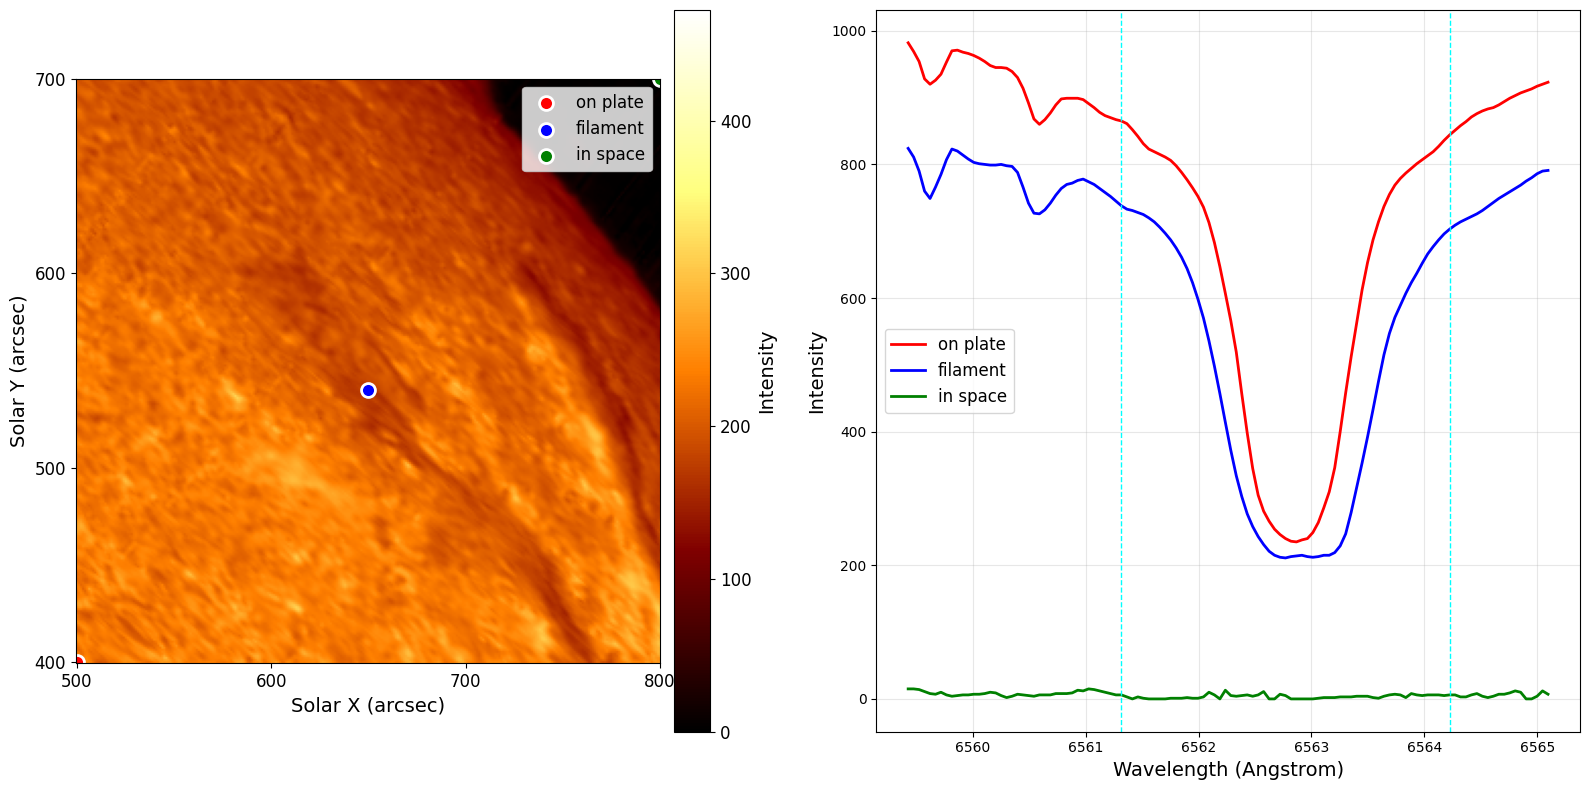

In [11]:
from src.velocity_los import wavelength_axis_from_header
demo_rsm = rsms[15]
headercore = sunpy.map.make_fitswcs_header(hacore, coord_HIS,
                                       reference_pixel = \
                                       [demo_rsm[1].header['CRPIX1'], demo_rsm[1].header['CRPIX2']] * u.pixel,
                                       scale = [0.5218 * 2, 0.5218 * 2] * u.arcsec / u.pixel,
                                       telescope = 'CHASE', instrument = 'RSM')

hacore_map = sunpy.map.Map(hacore, headercore)

ang_res = 0.5218 * 2
left, right, bottom, top = 500, 800, 400, 700
left_corner = SkyCoord(Tx=left * u.arcsec, Ty=bottom * u.arcsec, frame=hacore_map.coordinate_frame)
right_corner = SkyCoord(Tx=right * u.arcsec, Ty=top * u.arcsec, frame=hacore_map.coordinate_frame)

hacore_map_small = hacore_map.submap(left_corner, top_right=right_corner).data

sample_points = {
    'on plate': (500, 400),
    'filament': (650, 540),
    'in space': (800, 700)
}

fig, (ax_img, ax_spec) = plt.subplots(1, 2, figsize=(16, 8))

len_arc = (right - left) / 100 + 1
tick_pixelx = list(np.linspace(0, (right - left) / ang_res, int(len_arc)))
tick_pixely = list(np.linspace(0, (top - bottom) / ang_res, int(len_arc)))
tick_arcsecx = [int(i) for i in np.linspace(left, right, int(len_arc))]
tick_arcsecy = [int(i) for i in np.linspace(bottom, top, int(len_arc))]

im = ax_img.imshow(hacore_map_small, origin='lower', cmap='afmhot', vmin=0, vmax=4 * hacore_map.mean())
ax_img.set_xlabel('Solar X (arcsec)', fontsize=14)
ax_img.set_ylabel('Solar Y (arcsec)', fontsize=14)
ax_img.set_xticks(tick_pixelx)
ax_img.set_xticklabels(tick_arcsecx, fontsize=12)
ax_img.set_yticks(tick_pixely)
ax_img.set_yticklabels(tick_arcsecy, fontsize=12)

colors = ['red', 'blue', 'green']
spec_len = demo_rsm[1].data.shape[0]
wvl_ha = [demo_rsm[1].header['CRVAL3'] + i * demo_rsm[1].header['CDELT3'] for i in range(spec_len)]

central_pos = demo_rsm[1].header['CRPIX1'], demo_rsm[1].header['CRPIX2']
for idx, (label, (px, py)) in enumerate(sample_points.items()):
    if left <= px <= right and bottom <= py <= top:
        pix_x = (px - left) / ang_res
        pix_y = (py - bottom) / ang_res
        ax_img.scatter(pix_x, pix_y, s=100, color=colors[idx], marker='o', 
                      edgecolor='white', linewidth=2, label=label)
        
        spec = demo_rsm[1].data[:, int(central_pos[1] + py), int(central_pos[0] + px)]
        ax_spec.plot(wvl_ha, spec, color=colors[idx], label=label, linewidth=2)

ax_img.legend(fontsize=12, loc='upper right')
cbar = fig.colorbar(im, ax=ax_img, pad=0.02)
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Intensity', fontsize=14)

ax_spec.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax_spec.set_ylabel('Intensity', fontsize=14)
ax_spec.legend(fontsize=12)
ax_spec.grid(True, alpha=0.3)

wvl = wavelength_axis_from_header(demo_rsm[1].header, demo_rsm[1].data.shape[0])

center_idx = 68
half_width = 30
hacore_start_wv = wvl[center_idx - half_width]
hacore_end_wv = wvl[center_idx + half_width]
for x_line in (hacore_start_wv, hacore_end_wv):
    ax_spec.axvline(x_line, color='cyan', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

/tmp/ipykernel_1568198/137962427.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)


{'Rint_bg_median': 0.6672486066818237, 'alpha': 0.85, 'threshold': 0.5671613156795502, 'line_window_A': (6561.27, 6564.27), 'wing_left': (6560.5, 6561.0), 'wing_right': (6564.6, 6565.0), 'filament_pixels_in_roi': 1858}


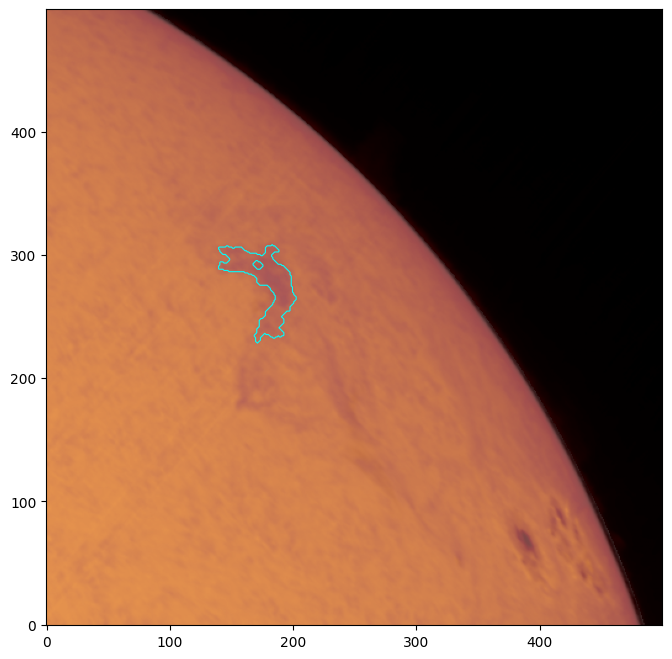

In [ ]:
from src.alignment import get_solar_center
from src.velocity_los import wavelength_axis_from_header
from skimage.morphology import remove_small_objects, binary_closing, disk
from matplotlib.lines import Line2D

def get_disk_mask(rsm):
    center = get_solar_center(rsm)
    radius = rsm[1].header['R_SUN']
    # create a limb mask , if sqrt(x^2 + y^2) > radius, then 0
    
    ny, nx = rsm[1].data.shape[1], rsm[1].data.shape[2]

    yy, xx = np.mgrid[:ny, :nx]
    r = np.sqrt((xx - center[0])**2 + (yy - center[1])**2)

    disk_mask = r <= radius

    return disk_mask

def compute_Rint_map(
    I,
    wvl,
    line_center_A=6562.77,
    line_half_width_A=1.5,
    wing_left=(6560.5, 6561.0),
    wing_right=(6564.6, 6565.0),
):
    """
    返回：
      Rint: 归一化线积分(平均)图，暗条更小
      valid: 有效像素（盘内且I_cont>0）
      wvl: 波长轴
    """
    nlambda, ny, nx = I.shape

    disk_mask = get_disk_mask(rsm)

    idx_wing = (
        ((wvl >= wing_left[0]) & (wvl <= wing_left[1])) |
        ((wvl >= wing_right[0]) & (wvl <= wing_right[1]))
    )
    if idx_wing.sum() < 2:
        raise ValueError("Wing windows invalid for current wavelength range.")

    I_cont = np.nanmean(I[idx_wing, :, :], axis=0)

    valid = disk_mask & np.isfinite(I_cont) & (I_cont > 0)

    # 归一化谱
    R = np.full((nlambda, ny, nx), np.nan, dtype=np.float32)
    R[:, valid] = (I[:, valid] / I_cont[valid]).astype(np.float32)

    lo = line_center_A - line_half_width_A
    hi = line_center_A + line_half_width_A
    idx_line = (wvl >= lo) & (wvl <= hi)

    if idx_line.sum() < 3:
        raise ValueError("Line integration window invalid for current wavelength range.")

    Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)

    # 日面外强制无效
    Rint[~disk_mask] = np.nan
    return Rint, valid, wvl

def get_filament_mask(
    rsm,
    roi_xy,            # (x0,x1,y0,y1) filament search region
    bg_xy,             # (x0,x1,y0,y1) nearby quiet-sun background region (no filament, no flare)
    alpha=0.90,        # threshold ratio
    line_center_A=6562.77,
    line_half_width_A=1.5,
    wing_left=(6560.5, 6561.0),
    wing_right=(6564.6, 6565.0),
    min_area=1000,
    close_radius=2,
):
    """
    返回：
      mask: filament mask (ny,nx)
      Rint: 归一化积分强度图
      meta: 含 Rint_bg 与阈值
    """
    Rint, valid, wvl = compute_Rint_map(
        rsm,
        line_center_A=line_center_A,
        line_half_width_A=line_half_width_A,
        wing_left=wing_left,
        wing_right=wing_right,
    )

    # 取背景中位数
    center = get_solar_center(rsm)
    bx0, bx1, by0, by1 = bg_xy
    bx0, bx1 = int(bx0 + center[0]), int(bx1 + center[0])
    by0, by1 = int(by0 + center[1]), int(by1 + center[1])
    Rbg = Rint[by0:by1, bx0:bx1]
    Rbg = Rbg[np.isfinite(Rbg)]
    if Rbg.size < 200:
        raise RuntimeError("Too few valid background pixels. Move/resize bg_xy.")

    Rint_bg = float(np.nanmedian(Rbg))
    thr = alpha * Rint_bg

    # 在 ROI 内阈值化
    x0, x1, y0, y1 = roi_xy
    x0, x1 = int(x0 + center[0]), int(x1 + center[0])
    y0, y1 = int(y0 + center[1]), int(y1 + center[1])
    Rroi = Rint[y0:y1, x0:x1]
    mask_roi = (Rroi < thr) & np.isfinite(Rroi)

    # 形态学清理
    mask_roi = binary_closing(mask_roi, disk(close_radius))
    #mask_roi = remove_small_objects(mask_roi, min_size=min_area)

    mask = np.zeros_like(Rint, dtype=bool)
    mask[y0:y1, x0:x1] = mask_roi

    meta = {
        "Rint_bg_median": Rint_bg,
        "alpha": alpha,
        "threshold": thr,
        "line_window_A": (line_center_A - line_half_width_A, line_center_A + line_half_width_A),
        "wing_left": wing_left,
        "wing_right": wing_right,
        "filament_pixels_in_roi": int(mask_roi.sum()),
    }
    return mask, Rint, meta

demo_rsm = rsms[15]
roi_xy = (400, 900, 300, 800)
bg_xy = (400, 500, 300, 400)
mask, Rint, meta = get_filament_mask(demo_rsm, roi_xy=roi_xy, bg_xy=bg_xy, alpha=0.85)
print(meta)
# plot
I = demo_rsm[1].data
hdr = demo_rsm[1].header
nlambda, ny, nx = I.shape
wvl = wavelength_axis_from_header(hdr, nlambda)

core_hw = 1.5
idx_core = (wvl >= 6562.77-core_hw) & (wvl <= 6562.8+core_hw)
Icore = np.nanmean(I[idx_core, :, :], axis=0)   # (ny,nx)

# 2) 用你“中心偏移像素 ROI”换算成绝对像素
cx, cy = get_solar_center(demo_rsm)
x0, x1, y0, y1 = roi_xy
xs0, xs1 = int(cx+x0), int(cx+x1)
ys0, ys1 = int(cy+y0), int(cy+y1)

# 3) 同一裁剪
Icore_small = Icore[ys0:ys1, xs0:xs1]
Rint_small  = Rint[ys0:ys1, xs0:xs1]
mask_small  = mask[ys0:ys1, xs0:xs1]

# 4) 叠加
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(Icore_small, origin='lower', cmap='afmhot', vmin=0, vmax=4*Icore_small.mean())
ax.imshow(Rint_small, origin='lower', cmap='gray_r', alpha=0.35)
ax.contour(mask_small, colors='cyan', linewidths=0.8)
plt.show()

In [93]:
import numpy as np
from skimage.morphology import remove_small_objects, binary_closing, disk
from src.velocity_los import wavelength_axis_from_header
from src.alignment import get_solar_center
from src import alignment

# 1) 对齐 3D 数据立方（推荐 use_fft=True）
reference_idx = 0
aligned_data, shifts = alignment.align_images_by_crpix(rsms, reference_idx=reference_idx, use_fft=True)

ref_center = get_solar_center(rsms[reference_idx])  # [CRPIX1, CRPIX2]
ref_radius = rsms[reference_idx][1].header["R_SUN"]

def disk_mask_from_center_radius(ny, nx, center_xy, radius_pix):
    cx, cy = float(center_xy[0]), float(center_xy[1])
    yy, xx = np.mgrid[:ny, :nx]
    r = np.sqrt((xx - cx) ** 2 + (yy - cy) ** 2)
    return r <= float(radius_pix)

def compute_Rint_map_from_cube(
    I_cube,
    hdr,
    disk_center_xy,
    disk_radius_pix,
    line_center_A=6562.77,
    line_half_width_A=1.5,
    wing_left=(6560.5, 6561.0),
    wing_right=(6564.6, 6565.0),
):
    """
    I_cube: (nlambda, ny, nx) 已对齐的数据
    返回: Rint (ny,nx), valid (ny,nx), wvl (nlambda,)
    """
    I = I_cube
    nlambda, ny, nx = I.shape
    wvl = wavelength_axis_from_header(hdr, nlambda)

    disk_mask = disk_mask_from_center_radius(ny, nx, disk_center_xy, disk_radius_pix)

    idx_wing = (
        ((wvl >= wing_left[0]) & (wvl <= wing_left[1])) |
        ((wvl >= wing_right[0]) & (wvl <= wing_right[1]))
    )
    if idx_wing.sum() < 2:
        raise ValueError("Wing windows invalid for current wavelength range.")

    I_cont = np.nanmean(I[idx_wing, :, :], axis=0)
    valid = disk_mask & np.isfinite(I_cont) & (I_cont > 0)

    R = np.full((nlambda, ny, nx), np.nan, dtype=np.float32)
    R[:, valid] = (I[:, valid] / I_cont[valid]).astype(np.float32)

    lo = line_center_A - line_half_width_A
    hi = line_center_A + line_half_width_A
    idx_line = (wvl >= lo) & (wvl <= hi)
    if idx_line.sum() < 3:
        raise ValueError("Line integration window invalid for current wavelength range.")

    Rint = np.nanmean(R[idx_line, :, :], axis=0).astype(np.float32)
    Rint[~disk_mask] = np.nan
    return Rint, valid, wvl

def filament_mask_from_Rint(
    Rint,
    center_xy,
    roi_xy,   # (x0,x1,y0,y1) 相对 center 的“像素偏移”
    bg_xy,    # 同上
    alpha=0.85,
    min_area=1000,
    close_radius=2,
):
    cx, cy = float(center_xy[0]), float(center_xy[1])

    bx0, bx1, by0, by1 = bg_xy
    bx0, bx1 = int(cx + bx0), int(cx + bx1)
    by0, by1 = int(cy + by0), int(cy + by1)

    Rbg = Rint[by0:by1, bx0:bx1]
    Rbg = Rbg[np.isfinite(Rbg)]
    if Rbg.size < 200:
        raise RuntimeError("Too few valid background pixels. Move/resize bg_xy.")

    Rint_bg = float(np.nanmedian(Rbg))
    thr = alpha * Rint_bg

    x0, x1, y0, y1 = roi_xy
    x0, x1 = int(cx + x0), int(cx + x1)
    y0, y1 = int(cy + y0), int(cy + y1)

    Rroi = Rint[y0:y1, x0:x1]
    mask_roi = (Rroi < thr) & np.isfinite(Rroi)

    mask_roi = binary_closing(mask_roi, disk(close_radius))
    mask_roi = remove_small_objects(mask_roi, min_size=min_area)

    mask = np.zeros_like(Rint, dtype=bool)
    mask[y0:y1, x0:x1] = mask_roi
    return mask, {"Rint_bg_median": Rint_bg, "alpha": alpha, "threshold": thr}

Frame 0: shift = [0.00, 0.00] pixels
Frame 1: shift = [6.29, 8.95] pixels
Frame 2: shift = [0.97, -1.74] pixels
Frame 3: shift = [7.40, 9.19] pixels
Frame 4: shift = [0.92, -1.64] pixels
Frame 5: shift = [6.54, 8.27] pixels
Frame 6: shift = [1.03, -0.45] pixels
Frame 7: shift = [5.60, 9.44] pixels
Frame 8: shift = [0.10, -1.39] pixels
Frame 9: shift = [7.58, 8.61] pixels
Frame 10: shift = [2.00, -2.25] pixels
Frame 11: shift = [7.70, 8.73] pixels
Frame 12: shift = [1.18, -1.04] pixels
Frame 13: shift = [6.77, 7.96] pixels
Frame 14: shift = [1.29, 1.10] pixels
Frame 15: shift = [7.75, 9.08] pixels
Frame 16: shift = [2.24, 2.24] pixels


/tmp/ipykernel_1568198/2191468438.py:59: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0).astype(np.float32)


5/17 done
10/17 done
15/17 done


In [ ]:
roi_xy = (400, 900, 300, 800)
bg_xy = (400, 500, 300, 400)

masks = []
Rints = []

for i, rsm in enumerate(rsms):
    I_aligned = aligned_data[i]
    hdr = rsm[1].header

    Rint, valid, wvl = compute_Rint_map_from_cube(
        I_aligned, hdr,
        disk_center_xy=ref_center,
        disk_radius_pix=ref_radius,
    )
    mask, meta = filament_mask_from_Rint(
        Rint,
        center_xy=ref_center,
        roi_xy=roi_xy,
        bg_xy=bg_xy,
        alpha=0.85,
        min_area=1000,
        close_radius=2,
    )

    Rints.append(Rint)
    masks.append(mask)

    if (i + 1) % 5 == 0:
        print(f"{i+1}/{len(rsms)} done")

If we simply use binary mask to generate 2d velocity, the result is not useable

(500, 500) (500, 500)
flct: nominal sliding box size = 12
flct: mean value of gamma^2/sigma^2 = 0.665068

flct: finished


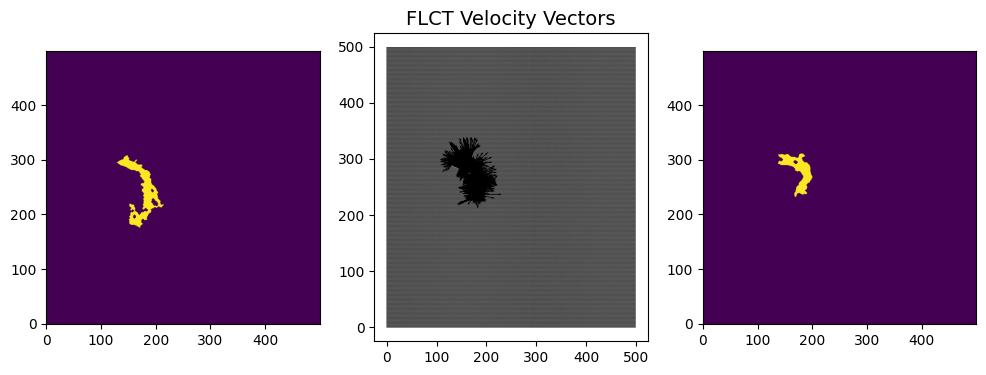

In [94]:
import pyflct

demo_rsm = rsms[10]
center = get_solar_center(demo_rsm)
x0, x1, y0, y1 = roi_xy
x0, x1 = int(x0 + center[0]), int(x1 + center[0])
y0, y1 = int(y0 + center[1]), int(y1 + center[1])

arcsec_per_pix = 1.0436
mask1 = (masks[10][y0:y1, x0:x1] == 1).astype(int)
mask2 = (masks[15][y0:y1, x0:x1] == 1).astype(int)
print(mask1.shape, mask2.shape)

vx, vy, vm = pyflct.flct(mask1, mask2, deltat=60, deltas=arcsec_per_pix, sigma=3)
U, V = np.meshgrid(np.arange(vx.shape[1]), np.arange(vx.shape[0]))

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(131)
plt.imshow(mask1, origin='lower')

ax2 = fig.add_subplot(132)
ax2.quiver(U, V, vx, vy, scale=1)
ax2.set_title('FLCT Velocity Vectors', fontsize=14)  

ax3 = fig.add_subplot(133)
plt.imshow(mask2, origin='lower')
plt.show()

Therefore, we should use intergrated normalized intensity between H-alpha core instead

In [129]:
import scipy.ndimage as ndi
from astropy.time import Time
import pyflct
import numpy as np

t1_idx = 10
t2_idx = 11
Rint_1 = Rints[t1_idx]
Rint_2 = Rints[t2_idx]
def compute_absortion_proxy(Rint_map):
    eps = 1e-6
    valid = np.isfinite(Rint_map)
    A = np.full_like(Rint_map, np.nan, dtype=np.float32)
    A[valid] = -np.log(np.clip(Rint_map[valid], a_min=eps, a_max=None))
    return A

A1 = compute_absortion_proxy(Rint_1)
A2 = compute_absortion_proxy(Rint_2)

In [130]:
x0, x1, y0, y1 = roi_xy
center = get_solar_center(rsms[10])
x0, x1 = int(x0 + center[0]), int(x1 + center[0])
y0, y1 = int(y0 + center[1]), int(y1 + center[1])
Rint_1_roi = Rint_1[y0:y1, x0:x1]
Rint_2_roi = Rint_2[y0:y1, x0:x1]
A1_roi = A1[y0:y1, x0:x1]
A2_roi = A2[y0:y1, x0:x1]
mask1 = masks[t1_idx]
mask1_roi = mask1[y0:y1, x0:x1]
mask2 = masks[t2_idx]
mask2_roi = mask2[y0:y1, x0:x1]

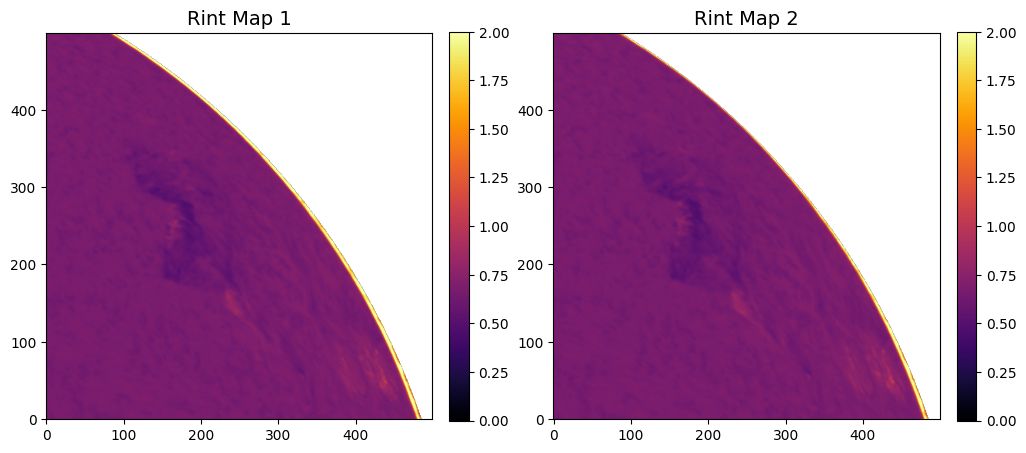

In [131]:
# plot A1, A2, and overplot mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(Rint_1_roi, origin='lower', cmap='inferno', vmin=0, vmax=2)
ax1.set_title('Rint Map 1', fontsize=14)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
im2 = ax2.imshow(Rint_2_roi, origin='lower', cmap='inferno', vmin=0, vmax=2)
ax2.set_title('Rint Map 2', fontsize=14)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.show()

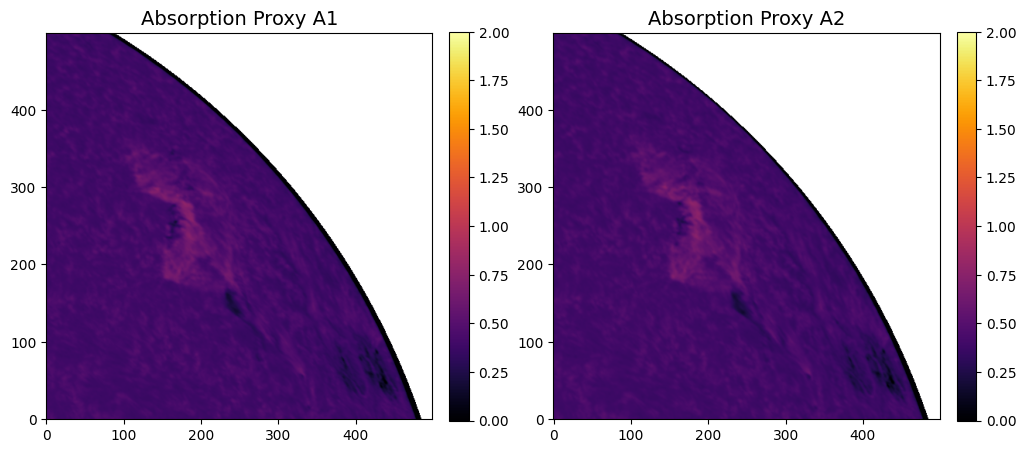

In [132]:
# plot A1, A2, and overplot mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(A1_roi, origin='lower', cmap='inferno', vmin=0, vmax=2)
ax1.set_title('Absorption Proxy A1', fontsize=14)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
im2 = ax2.imshow(A2_roi, origin='lower', cmap='inferno', vmin=0, vmax=2)
ax2.set_title('Absorption Proxy A2', fontsize=14)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.show()

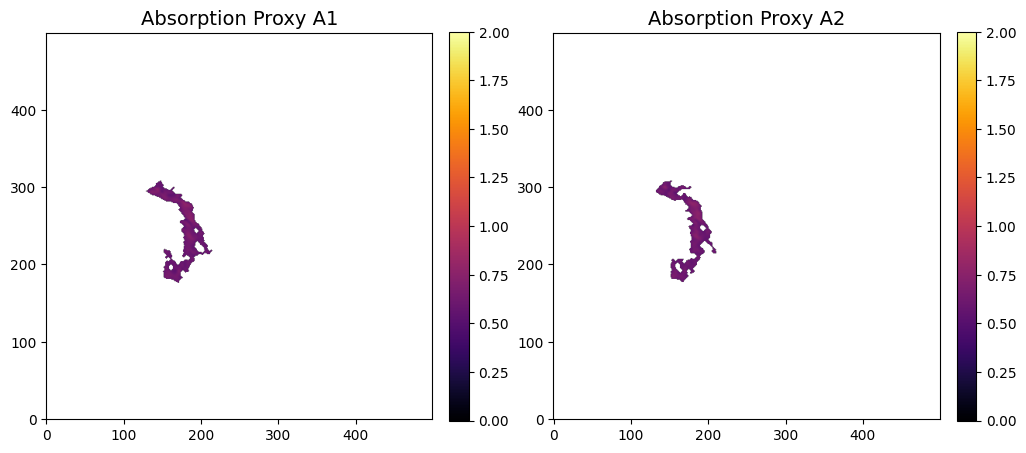

In [133]:
# plot A1, A2, and overplot mask
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
im1 = ax1.imshow(np.where(mask1_roi, A1_roi, np.nan), origin='lower', cmap='inferno', vmin=0, vmax=2)
ax1.set_title('Absorption Proxy A1', fontsize=14)
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
im2 = ax2.imshow(np.where(mask2_roi, A2_roi, np.nan), origin='lower', cmap='inferno', vmin=0, vmax=2)
ax2.set_title('Absorption Proxy A2', fontsize=14)
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
plt.show()

flct: nominal sliding box size = 16
flct: mean value of gamma^2/sigma^2 = 0.400343

flct: finished


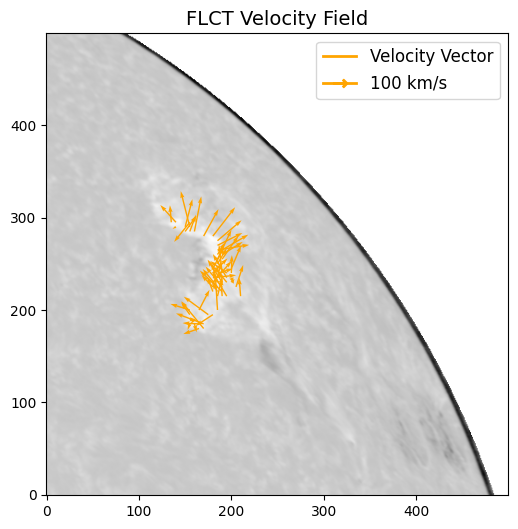

In [146]:
# A_roi
x0, x1, y0, y1 = roi_xy
center = get_solar_center(rsms[10])
x0, x1 = int(x0 + center[0]), int(x1 + center[0])
y0, y1 = int(y0 + center[1]), int(y1 + center[1])
A1_roi = A1[y0:y1, x0:x1]
A2_roi = A2[y0:y1, x0:x1]

import numpy as np
import scipy.ndimage as ndi

def flct_feature_field(A, smooth=2.0, bg=20.0):
    """
    A: 吸收proxy（越大越暗）
    返回：适合FLCT的特征场（强调纹理/边缘）
    """
    A0 = np.nan_to_num(A, nan=np.nanmedian(A))

    # 1) 平滑抑噪
    As = ndi.gaussian_filter(A0, smooth)

    # 2) 去大尺度背景（带通）
    Ahp = As - ndi.gaussian_filter(As, bg)

    # 3) 梯度增强：让“边界/细结构”成为跟踪对象
    gx = ndi.sobel(Ahp, axis=1)
    gy = ndi.sobel(Ahp, axis=0)
    G  = np.hypot(gx, gy)

    # 4) 再轻度平滑，避免梯度噪声
    G = ndi.gaussian_filter(G, 1.0)

    return G

G1 = flct_feature_field(A1_roi, smooth=2.0, bg=20.0)
G2 = flct_feature_field(A2_roi, smooth=2.0, bg=20.0)

# 真实时间间隔
t1 = Time(rsms[t1_idx][1].header["DATE_OBS"])
t2 = Time(rsms[t2_idx][1].header["DATE_OBS"])
deltat = (t2 - t1).to_value("s")

arcsec_per_pix = 1.0436
km_per_arcsec = 725.0 # approximate at Sun center
km_per_pix = arcsec_per_pix * km_per_arcsec
vx, vy, vm = pyflct.flct(G1, G2, deltat=deltat, deltas=km_per_pix, sigma=4)
step = 5
Y, X = np.mgrid[0:vx.shape[0]:step, 0:vx.shape[1]:step]

vxq = vx[0:vx.shape[0]:step, 0:vx.shape[1]:step]
vyq = vy[0:vx.shape[0]:step, 0:vx.shape[1]:step]

vmod = np.sqrt(vx**2 + vy**2)
vmin, vmax = np.nanpercentile(vmod, [10, 95])
good = mask1_roi & mask2_roi & (vmod >= vmin) & (vmod <= vmax)


fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(A1_roi, origin="lower", cmap="gray")
ax.quiver(X[good[::step,::step]],
          Y[good[::step,::step]],
          vxq[good[::step,::step]],
          vyq[good[::step,::step]],
          scale=200, width=0.003,
          color='orange')
ax.set_title("FLCT Velocity Field", fontsize=14)
# add vector reference
legend_elements = [Line2D([0], [0], color='orange', lw=2, label='Velocity Vector'),
                   Line2D([0], [0], color='orange', lw=2, marker=r'$\rightarrow$', markersize=10,
                          label='100 km/s', markerfacecolor='orange', markeredgecolor='orange')]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.show()

In [92]:
deltat

np.float64(353.9999999999978)

## Calculate LOS Velocity

### Cloud Model

In [5]:
import numpy as np

def background_profile(rsm, I, bg_xy):
    center = get_solar_center(rsm)
    sy, sx = np.arange(int(center[1] + bg_xy[2]), int(center[1] + bg_xy[3])), np.arange(int(center[0] + bg_xy[0]), int(center[0] + bg_xy[1]))
    # I[:, sy, sx] -> (nlambda, y, x)
    Ibg = I[:, sy, sx]
    # 对空间维度取中位数，得到 (nlambda,)
    return np.nanmedian(Ibg.reshape(Ibg.shape[0], -1), axis=1)


from scipy.optimize import curve_fit

C_KMS = 299792.458  # km/s

def cloud_model_I(lam, tau0, dlam, dlamD, S, I0_interp, lam0=6562.8):
    """
    lam: (n,) Å
    I0_interp: callable, 返回 I0(lam)
    """
    I0 = I0_interp(lam)
    tau = tau0 * np.exp(-((lam - lam0 - dlam) / dlamD)**2)
    e = np.exp(-tau)
    return I0 * e + S * (1 - e)

def fit_cloud_pixel(lam, Iobs, I0_lam, lam0=6562.8, fit_window=1.5):
    # 拟合窗口
    m = (lam >= lam0-fit_window) & (lam <= lam0+fit_window)
    x = lam[m]
    y = Iobs[m]
    I0y = I0_lam[m]

    # 跳过坏像素
    if np.any(~np.isfinite(y)) or np.any(~np.isfinite(I0y)):
        return None

    # 用线性插值提供 I0(lam)
    def I0_interp(xx):
        return np.interp(xx, x, I0y)

    # 初值（很重要）
    # 估计 S：线翼附近的强度下界（粗略）
    S0 = np.nanpercentile(y, 10)
    # 估计 dlam：用最小值位置粗估
    dlam0 = x[np.argmin(y)] - lam0
    # 估计 dlamD：经验给 0.3~0.6 Å
    dlamD0 = 0.4
    # tau0：给 1~3 的量级
    tau00 = 1.5

    p0 = [tau00, dlam0, dlamD0, S0]
    # 约束范围（避免发散）
    bounds = (
        [0.01, -1.0, 0.05, 0.0],    # lower
        [10.0,  1.0,  2.0,  np.max(I0y)]  # upper
    )

    def model(xx, tau0, dlam, dlamD, S):
        return cloud_model_I(xx, tau0, dlam, dlamD, S, I0_interp, lam0=lam0)

    try:
        popt, pcov = curve_fit(model, x, y, p0=p0, bounds=bounds, maxfev=5000)
    except Exception:
        return None

    tau0, dlam, dlamD, S = popt
    vlos = (C_KMS / lam0) * dlam
    return dict(tau0=tau0, dlam=dlam, dlamD=dlamD, S=S, vlos=vlos)

def fit_cloud_on_mask(rsm, I, wvl, mask, bg_xy, lam0=6562.8, step=1):
    I0_lam = background_profile(rsm, I, bg_xy)  # (nlambda,)

    ny, nx = mask.shape
    vmap = np.full((ny, nx), np.nan, dtype=np.float32)
    tau_map = np.full((ny, nx), np.nan, dtype=np.float32)

    ys, xs = np.where(mask)
    # 可抽样：step>1 会加速
    for k in range(0, len(ys), step):
        y, x = ys[k], xs[k]
        res = fit_cloud_pixel(wvl, I[:, y, x], I0_lam, lam0=lam0, fit_window=1.5)
        if res is None:
            continue
        vmap[y, x] = res["vlos"]
        tau_map[y, x] = res["tau0"]

    return vmap, tau_map

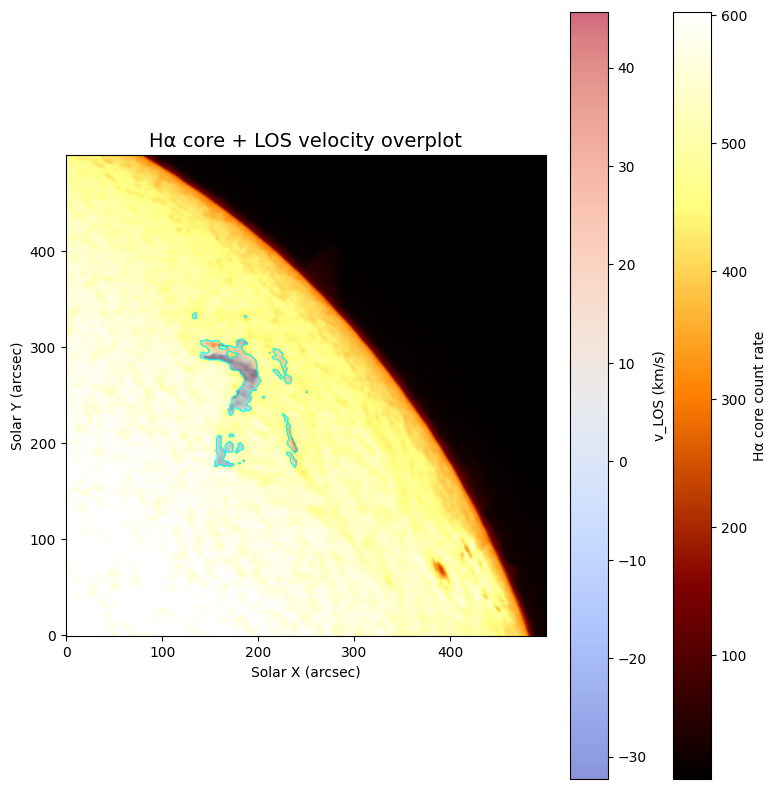

In [ ]:
idx = 15
demo_rsm = rsms[idx]
wvl = wavelength_axis_from_header(demo_rsm[1].header, demo_rsm[1].data.shape[0])
demo_mask = masks[idx]
bg_xy = (400, 500, 300, 400)
vmap, tau_map = fit_cloud_on_mask(demo_rsm, demo_rsm[1].data, wvl, demo_mask, bg_xy)

# plot
I = demo_rsm[1].data
hdr = demo_rsm[1].header
nlambda, ny, nx = I.shape
wvl = wavelength_axis_from_header(hdr, nlambda)

core_hw = 1.5
idx_core = (wvl >= 6562.77-core_hw) & (wvl <= 6562.8+core_hw)
Icore = np.nanmean(I[idx_core, :, :], axis=0)   # (ny,nx)

cx, cy = get_solar_center(demo_rsm)
x0, x1, y0, y1 = roi_xy
xs0, xs1 = int(cx+x0), int(cx+x1)
ys0, ys1 = int(cy+y0), int(cy+y1)

Icore_small = Icore[ys0:ys1, xs0:xs1]
Rint_small  = Rint[ys0:ys1, xs0:xs1]
mask_small  = mask[ys0:ys1, xs0:xs1]
vmap_small  = vmap[ys0:ys1, xs0:xs1]

fig, ax = plt.subplots(figsize=(8, 8))
im_core = ax.imshow(
    Icore_small, origin='lower', cmap='afmhot',
    vmin=np.nanpercentile(Icore_small[np.isfinite(Icore_small)], 5),
    vmax=np.nanpercentile(Icore_small[np.isfinite(Icore_small)], 95),
)
im_vel = ax.imshow(
    vmap_small, origin='lower', cmap='coolwarm', alpha=0.6,
    vmin=np.nanpercentile(vmap_small[np.isfinite(vmap_small)], 5),
    vmax=np.nanpercentile(vmap_small[np.isfinite(vmap_small)], 99),
)
ax.contour(mask_small, colors='cyan', linewidths=0.8)
ax.set_title('Hα core + LOS velocity overplot', fontsize=14)
ax.set_xlabel('Solar X (arcsec)')
ax.set_ylabel('Solar Y (arcsec)')

cbar_core = fig.colorbar(im_core, ax=ax, pad=0.02)
cbar_core.set_label('Hα core count rate')
cbar_vel = fig.colorbar(im_vel, ax=ax, pad=0.04)
cbar_vel.set_label('v_LOS (km/s)')

plt.tight_layout()
plt.show()

### Video

In [ ]:
import os, subprocess, numpy as np, matplotlib.pyplot as plt
import matplotlib.pyplot as plt

output_dir = "./visuals"
frames_dir = os.path.join(output_dir, "los_frames")
os.makedirs(frames_dir, exist_ok=True)

roi_xy = (400, 900, 300, 800)
bg_xy = (400, 500, 300, 400)

masks, Rints, vmaps, taus = [], [], [], []

for idx, rsm in enumerate(rsms):
    mask, Rint, meta = get_filament_mask(rsm, roi_xy=roi_xy, bg_xy=bg_xy, alpha=0.85)
    masks.append(mask)
    Rints.append(Rint)

    wvl = wavelength_axis_from_header(rsm[1].header, rsm[1].data.shape[0])
    vmap, tau_map = fit_cloud_on_mask(rsm, rsm[1].data, wvl, mask, bg_xy, step=1)
    vmaps.append(vmap)
    taus.append(tau_map)

    I = rsm[1].data
    core_hw = 1.5
    idx_core = (wvl >= 6562.77-core_hw) & (wvl <= 6562.8+core_hw)
    Icore = np.nanmean(I[idx_core, :, :], axis=0)

    cx, cy = get_solar_center(rsm)
    x0, x1, y0, y1 = roi_xy
    xs0, xs1 = int(cx+x0), int(cx+x1)
    ys0, ys1 = int(cy+y0), int(cy+y1)

    Icore_small = Icore[ys0:ys1, xs0:xs1]
    mask_small  = mask[ys0:ys1, xs0:xs1]
    vmap_small  = vmap[ys0:ys1, xs0:xs1]

    finite_core = np.isfinite(Icore_small)
    finite_vmap = np.isfinite(vmap_small)

    fig, ax = plt.subplots(figsize=(8, 8))
    im_core = ax.imshow(
        Icore_small, origin='lower', cmap='afmhot',
        vmin=np.nanpercentile(Icore_small[finite_core], 5),
        vmax=np.nanpercentile(Icore_small[finite_core], 95),
    )
    im_vel = ax.imshow(
        vmap_small, origin='lower', cmap='coolwarm', alpha=0.6,
        vmin=np.nanpercentile(vmap_small[finite_vmap], 5),
        vmax=np.nanpercentile(vmap_small[finite_vmap], 99),
    )
    ax.contour(mask_small, colors='cyan', linewidths=0.8)
    ax.set_title(f"Hα core + LOS velocity (frame {idx})", fontsize=12)
    ax.set_xlabel('Solar X (arcsec)')
    ax.set_ylabel('Solar Y (arcsec)')

    cbar_core = fig.colorbar(im_core, ax=ax, pad=0.02)
    cbar_core.set_label('Hα core count rate')
    cbar_vel = fig.colorbar(im_vel, ax=ax, pad=0.04)
    cbar_vel.set_label('v_LOS (km/s)')

    plt.tight_layout()
    plt.savefig(os.path.join(frames_dir, f"frame_{idx:04d}.png"), dpi=150)
    plt.close(fig)

subprocess.run(
    [
        "ffmpeg", "-y",
        "-r", "5",
        "-i", os.path.join(frames_dir, "frame_%04d.png"),
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        os.path.join(output_dir, "los_velocity.mp4"),
    ],
    check=True,
)
print("✓ 视频已生成:", os.path.join(output_dir, "los_velocity.mp4"))

In [ ]:
import os, subprocess, glob
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from threading import Lock
from astropy.io import fits

output_dir = "./visuals"
frames_dir = os.path.join(output_dir, "los_frames")
os.makedirs(frames_dir, exist_ok=True)

# 重建文件列表（在 worker 里打开 fits，避免把 HDUList 传给子进程）
data_dir = "/data1/yiwen/event_analysis/noaa_14272/chase"
file_paths = sorted(glob.glob(os.path.join(data_dir, "*.fits")))

roi_xy = (400, 900, 300, 800)
bg_xy = (400, 500, 300, 400)

# worker：在子进程中计算 mask, Rint, vmap, tau
def _compute_maps_worker(args):
    idx, path, roi_xy, bg_xy = args
    import numpy as np
    from astropy.io import fits
    from src.velocity_los import wavelength_axis_from_header
    # 依赖 notebook 中定义的函数 get_filament_mask, fit_cloud_on_mask, get_solar_center
    # 需要从主环境导入；如果不可用，可将相关函数移动到 src 模块。
    rsm = fits.open(path)
    # 计算 mask 与 Rint
    mask, Rint, meta = get_filament_mask(rsm, roi_xy=roi_xy, bg_xy=bg_xy, alpha=0.85)
    wvl = wavelength_axis_from_header(rsm[1].header, rsm[1].data.shape[0])
    vmap, tau_map = fit_cloud_on_mask(rsm, rsm[1].data, wvl, mask, bg_xy, step=1)
    rsm.close()
    return idx, mask, Rint.astype(np.float32), vmap.astype(np.float32), tau_map.astype(np.float32)

# 并行提交任务
args_list = [(i, p, roi_xy, bg_xy) for i, p in enumerate(file_paths)]
results = [None] * len(args_list)
max_workers = min(8, os.cpu_count() or 4)
with ProcessPoolExecutor(max_workers=max_workers) as ex:
    for idx, mask, Rint, vmap, tau in ex.map(_compute_maps_worker, args_list):
        results[idx] = (mask, Rint, vmap, tau)
print(f"✓ 并行计算完成：{len(results)} 帧")

# 主进程绘图（线程并行但保护 matplotlib）
_MPL_PLOT_LOCK = Lock()
def _render_plot_frame(item):
    idx, (mask, Rint, vmap, tau) = item
    import numpy as np
    import matplotlib.pyplot as plt
    # 读取 rsm 用于获取 Icore 与中心（如果需要）
    from astropy.io import fits
    path = file_paths[idx]
    rsm = fits.open(path)
    wvl = wavelength_axis_from_header(rsm[1].header, rsm[1].data.shape[0])
    core_hw = 1.5
    idx_core = (wvl >= 6562.77-core_hw) & (wvl <= 6562.8+core_hw)
    Icore = np.nanmean(rsm[1].data[idx_core, :, :], axis=0)
    cx, cy = get_solar_center(rsm)
    x0, x1, y0, y1 = roi_xy
    xs0, xs1 = int(cx+x0), int(cx+x1)
    ys0, ys1 = int(cy+y0), int(cy+y1)
    Icore_small = Icore[ys0:ys1, xs0:xs1]
    mask_small  = mask[ys0:ys1, xs0:xs1]
    vmap_small  = vmap[ys0:ys1, xs0:xs1]
    rsm.close()

    finite_core = np.isfinite(Icore_small)
    finite_vmap = np.isfinite(vmap_small)

    with _MPL_PLOT_LOCK:
        fig, ax = plt.subplots(figsize=(8,8))
        im_core = ax.imshow(
            Icore_small, origin='lower', cmap='afmhot',
            vmin=np.nanpercentile(Icore_small[finite_core], 5),
            vmax=np.nanpercentile(Icore_small[finite_core], 95),
        )
        im_vel = ax.imshow(
            vmap_small, origin='lower', cmap='coolwarm', alpha=0.6,
            vmin=np.nanpercentile(vmap_small[finite_vmap], 5) if finite_vmap.any() else np.nan,
            vmax=np.nanpercentile(vmap_small[finite_vmap], 99) if finite_vmap.any() else np.nan,
        )
        ax.contour(mask_small, colors='cyan', linewidths=0.8)
        ax.set_title(f"Hα core + LOS velocity (frame {idx})", fontsize=12)
        ax.set_xlabel('Solar X (arcsec)')
        ax.set_ylabel('Solar Y (arcsec)')
        cbar_core = fig.colorbar(im_core, ax=ax, pad=0.02)
        cbar_core.set_label('Hα core count rate')
        cbar_vel = fig.colorbar(im_vel, ax=ax, pad=0.04)
        cbar_vel.set_label('v_LOS (km/s)')
        plt.tight_layout()
        out_path = os.path.join(frames_dir, f"frame_{idx:04d}.png")
        plt.savefig(out_path, dpi=150)
        plt.close(fig)
    return idx

# 使用线程池并行保存图片（matplotlib 受锁保护）
with ThreadPoolExecutor(max_workers=4) as tex:
    items = list(enumerate(results))
    for count, _ in enumerate(tex.map(_render_plot_frame, items), 1):
        if count % 5 == 0:
            print(f"  已保存 {count}/{len(items)} 帧")

# 合并为视频
subprocess.run(
    [
        "ffmpeg", "-y",
        "-r", "5",
        "-i", os.path.join(frames_dir, "frame_%04d.png"),
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        os.path.join(output_dir, "los_velocity.mp4"),
    ],
    check=True,
)
print("✓ 视频已生成:", os.path.join(output_dir, "los_velocity.mp4"))


In [10]:
import os, subprocess, glob
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from threading import Lock
from astropy.io import fits

output_dir = "./visuals"
frames_dir = os.path.join(output_dir, "los_frames")
os.makedirs(frames_dir, exist_ok=True)

# 重建文件列表（在 worker 里打开 fits，避免把 HDUList 传给子进程）
data_dir = "/data1/yiwen/event_analysis/noaa_14272/chase"
file_paths = sorted(glob.glob(os.path.join(data_dir, "*.fits")))

roi_xy = (400, 900, 300, 800)
bg_xy = (400, 500, 300, 400)

# worker：在子进程中计算 mask, Rint, vmap, tau
def _compute_maps_worker(args):
    idx, path, roi_xy, bg_xy = args
    import numpy as np
    from astropy.io import fits
    from src.velocity_los import wavelength_axis_from_header
    rsm = fits.open(path)
    # 计算 mask 与 Rint
    mask, Rint, meta = get_filament_mask(rsm, roi_xy=roi_xy, bg_xy=bg_xy, alpha=0.9)
    wvl = wavelength_axis_from_header(rsm[1].header, rsm[1].data.shape[0])
    vmap, tau_map = fit_cloud_on_mask(rsm, rsm[1].data, wvl, mask, bg_xy, step=1)
    rsm.close()
    return idx, mask, Rint.astype(np.float32), vmap.astype(np.float32), tau_map.astype(np.float32)

# 并行提交任务
args_list = [(i, p, roi_xy, bg_xy) for i, p in enumerate(file_paths)]
results = [None] * len(args_list)
max_workers = 8
with ProcessPoolExecutor(max_workers=max_workers) as ex:
    for idx, mask, Rint, vmap, tau in ex.map(_compute_maps_worker, args_list):
        results[idx] = (mask, Rint, vmap, tau)
print(f"✓ 并行计算完成：{len(results)} 帧")

# 主进程绘图（线程并行但保护 matplotlib）
_MPL_PLOT_LOCK = Lock()
def _render_plot_frame(item):
    idx, (mask, Rint, vmap, tau) = item
    import numpy as np
    import matplotlib.pyplot as plt
    # 读取 rsm 用于获取 Icore 与中心（如果需要）
    from astropy.io import fits
    path = file_paths[idx]
    rsm = fits.open(path)
    wvl = wavelength_axis_from_header(rsm[1].header, rsm[1].data.shape[0])
    core_hw = 1.5
    idx_core = (wvl >= 6562.77-core_hw) & (wvl <= 6562.8+core_hw)
    Icore = np.nanmean(rsm[1].data[idx_core, :, :], axis=0)
    cx, cy = get_solar_center(rsm)
    x0, x1, y0, y1 = roi_xy
    xs0, xs1 = int(cx+x0), int(cx+x1)
    ys0, ys1 = int(cy+y0), int(cy+y1)
    Icore_small = Icore[ys0:ys1, xs0:xs1]
    mask_small  = mask[ys0:ys1, xs0:xs1]
    vmap_small  = vmap[ys0:ys1, xs0:xs1]
    rsm.close()

    finite_core = np.isfinite(Icore_small)
    finite_vmap = np.isfinite(vmap_small)

    with _MPL_PLOT_LOCK:
        fig, ax = plt.subplots(figsize=(8,8))
        im_core = ax.imshow(
            Icore_small, origin='lower', cmap='afmhot',
            vmin=np.nanpercentile(Icore_small[finite_core], 5),
            vmax=np.nanpercentile(Icore_small[finite_core], 95),
        )
        im_vel = ax.imshow(
            vmap_small, origin='lower', cmap='coolwarm', alpha=0.6,
            vmin=np.nanpercentile(vmap_small[finite_vmap], 5) if finite_vmap.any() else np.nan,
            vmax=np.nanpercentile(vmap_small[finite_vmap], 99) if finite_vmap.any() else np.nan,
        )
        ax.contour(mask_small, colors='cyan', linewidths=0.8)
        ax.set_title(f"Hα core + LOS velocity (frame {idx})", fontsize=12)
        ax.set_xlabel('Solar X (arcsec)')
        ax.set_ylabel('Solar Y (arcsec)')
        cbar_core = fig.colorbar(im_core, ax=ax, pad=0.02)
        cbar_core.set_label('Hα core count rate')
        cbar_vel = fig.colorbar(im_vel, ax=ax, pad=0.04)
        cbar_vel.set_label('v_LOS (km/s)')
        plt.tight_layout()
        out_path = os.path.join(frames_dir, f"frame_{idx:04d}.png")
        plt.savefig(out_path, dpi=150)
        plt.close(fig)
    return idx

# 使用线程池并行保存图片（matplotlib 受锁保护）
with ThreadPoolExecutor(max_workers=4) as tex:
    items = list(enumerate(results))
    for count, _ in enumerate(tex.map(_render_plot_frame, items), 1):
        if count % 5 == 0:
            print(f"  已保存 {count}/{len(items)} 帧")

# 合并为视频
subprocess.run(
    [
        "ffmpeg", "-y",
        "-r", "5",
        "-i", os.path.join(frames_dir, "frame_%04d.png"),
        "-c:v", "libx264",
        "-pix_fmt", "yuv420p",
        os.path.join(output_dir, "los_velocity.mp4"),
    ],
    check=True,
)
print("✓ 视频已生成:", os.path.join(output_dir, "los_velocity.mp4"))

/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning: Mean of empty slice
  Rint = np.nanmean(R[idx_line, :, :], axis=0)  # (ny,nx)
/tmp/ipykernel_1169344/3529813409.py:62: RuntimeWarning

✓ 并行计算完成：17 帧
  已保存 5/17 帧
  已保存 10/17 帧
  已保存 15/17 帧


ffmpeg version 4.2.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/tmp/build/80754af9/ffmpeg_1587154242452/_h_env_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placehold_placeho --cc=/tmp/build/80754af9/ffmpeg_1587154242452/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --enable-avresample --enable-gmp --enable-hardcoded-tables --enable-libfreetype --enable-libvpx --enable-pthreads --enable-libopus --enable-postproc --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --disable-nonfree --enable-gpl --enable-gnutls --disable-openssl --enable-libopenh264 --enable-libx264
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100


✓ 视频已生成: ./visuals/los_velocity.mp4


frame=   17 fps=0.0 q=-1.0 Lsize=     308kB time=00:00:02.80 bitrate= 900.3kbits/s speed=4.98x    
video:307kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.336574%
[libx264 @ 0x618e21b4da80] frame I:1     Avg QP:16.92  size: 53884
[libx264 @ 0x618e21b4da80] frame P:5     Avg QP:17.91  size: 21032
[libx264 @ 0x618e21b4da80] frame B:11    Avg QP:19.41  size: 14030
[libx264 @ 0x618e21b4da80] consecutive B-frames:  5.9% 23.5%  0.0% 70.6%
[libx264 @ 0x618e21b4da80] mb I  I16..4: 20.6% 68.1% 11.4%
[libx264 @ 0x618e21b4da80] mb P  I16..4:  0.9%  1.5%  1.4%  P16..4: 17.0%  7.6%  5.1%  0.0%  0.0%    skip:66.5%
[libx264 @ 0x618e21b4da80] mb B  I16..4:  0.1%  0.2%  0.9%  B16..8: 18.1%  3.3%  1.2%  direct: 4.3%  skip:71.8%  L0:49.1% L1:44.0% BI: 6.8%
[libx264 @ 0x618e21b4da80] 8x8 transform intra:58.7% inter:80.2%
[libx264 @ 0x618e21b4da80] coded y,uvDC,uvAC intra: 30.1% 42.1% 38.0% inter: 6.4% 16.6% 9.9%
[libx264 @ 0x618e21b4da80] i16 v,h,dc,p: 62% 29%  6%  3%
[l

## Output 3D velocity